### Customer Churn Analysis

Our task is to predict the outflow of customers for the telecom operator. If the user plans to leave, he/she will be offered promotional codes and special conditions. Our task is to compare different models by AUC ROC. It is important to choose a stable model.

#### Description of services

The operator provides two main types of services:

1. Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time.  
2. Internet. The connection can be of two types: via a telephone line (DSL or fiber optic cable).  

The following services are also available:

- Internet security: antivirus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*);
- Dedicated technical support line (*TechSupport*);
- Cloud file storage for data backup (*OnlineBackup*);
- Streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*).

Clients can pay for services every month or sign a contract for 1-2 years.
Various payment methods and the possibility of receiving an electronic check are available.

#### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — information about contracts;
- `personal.csv` — clients details;
- `internet.csv` — information about internet services;
- `phone.csv` — information about phone services.

Во всех файлах столбец `customerID` содержит код клиента.

Description of columns:
- BeginDate - the date of the beginning of using the services,  
- EndDate – end date of using the services,  
- Type - payment type: monthly, annual, etc.,  
- PaperlessBilling - cashless payment,  
- PaymentMethod - payment method,  
- MonthlyCharges - monthly spending on services,  
- TotalCharges - total money spent on services,  
- Dependents - the presence of dependents,  
- Senior Citizen - the presence of a pension status by age,  
- Partner - the presence of a spouse,  
- MultipleLines - the ability to maintain parallel lines during a call  

Information about contracts is current as of Feb-20.

The project has the following sections:  
[1. General information and exploratory data analysis](#1)  
[2. Data preparation](#2)  
[3. Model Training](#3)   
[4. Summary](#4)  

### <a id="1">1. General information and exploratory data analysis</a>

In [1]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve,roc_auc_score,precision_recall_curve
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [2]:
df_c = pd.read_csv('datasets/final_provider/contract.csv')
df_i= pd.read_csv('datasets/final_provider/internet.csv')
df_p= pd.read_csv('datasets/final_provider/personal.csv')
df_ph= pd.read_csv('datasets/final_provider/phone.csv')

In [3]:
df_c.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_i.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
df_p.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
df_ph.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Let's check the size:

In [7]:
dfs = [('contract',df_c), ('internet',df_i), ('personal',df_p), ('phone',df_ph)]

for name,df in dfs:
    print(name, df.shape)

contract (7043, 8)
internet (5517, 8)
personal (7043, 5)
phone (6361, 2)


In [8]:
for name,df in dfs:
    print('\033[1m' + f"{name}".upper() + '\033[0m')
    df.info()
    print()

CONTRACT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

INTERNET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBack

We can join all tables into one:

In [9]:
df_c['customerID'].isin(df_p['customerID']).value_counts()

True    7043
Name: customerID, dtype: int64

In [10]:
df=pd.merge(df_c,df_p, on="customerID", how="left")
df=pd.merge(df,df_i, on="customerID", how="left")
df=pd.merge(df,df_ph, on="customerID", how="left")

In [11]:
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')

Now we will compare the distributions of monthly charges (MonthlyCharges) of all customers and those who left. Let's construct distribution histograms.

array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

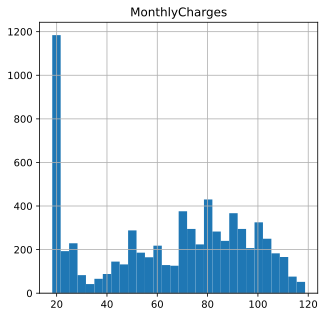

In [13]:
df[['MonthlyCharges']].hist(bins=30, figsize=(5, 5))

array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

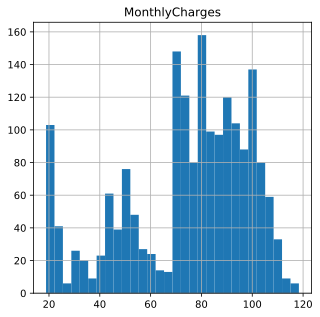

In [14]:
df.query('EndDate != "No"')[['MonthlyCharges']].hist(bins=30, figsize=(5, 5)) 

We can see that in the second graph for clients who left, we have higher monthly spending on services.

For each group, we calculate statistics: average, minimum and maximum values, median and values of 25% and 75% quartiles.

In [15]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


In [16]:
df.query('EndDate != "No"').describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,0.254682
std,24.666053,1890.822994,0.435799
min,18.850000,18.850000,0.000000
25%,56.150000,134.500000,0.000000
50%,79.650000,703.550000,0.000000
75%,94.200000,2331.300000,1.000000
max,118.350000,8684.800000,1.000000


In [17]:
df.query('EndDate == "No"').describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,5174.000000,5163.000000,5174.000000
mean,61.265124,2555.344141,0.128721
std,31.092648,2329.456984,0.334923
min,18.250000,18.800000,0.000000
25%,25.100000,577.825000,0.000000
50%,64.425000,1683.600000,0.000000
75%,88.400000,4264.125000,0.000000
max,118.750000,8672.450000,1.000000


For those who left, the average monthly fee was 74 rubles, while for those who still use the services, the average monthly fee was 61 rubles. Perhaps they were unhappy with the price.

We need to fill in the missing values:

In [18]:
missing_percent=(df.isnull().sum() * 100 / len(df)).round(1)
missing_percent.sort_values(ascending=False)

StreamingMovies     21.7
StreamingTV         21.7
TechSupport         21.7
DeviceProtection    21.7
OnlineBackup        21.7
OnlineSecurity      21.7
InternetService     21.7
MultipleLines        9.7
TotalCharges         0.2
Dependents           0.0
customerID           0.0
BeginDate            0.0
SeniorCitizen        0.0
gender               0.0
MonthlyCharges       0.0
PaymentMethod        0.0
PaperlessBilling     0.0
Type                 0.0
EndDate              0.0
Partner              0.0
dtype: float64

In [19]:
df["MultipleLines"] = df["MultipleLines"].fillna("NoService")

In [20]:
df["InternetService"] = df["InternetService"].fillna("NoService")

In [21]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NoService
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NoService
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


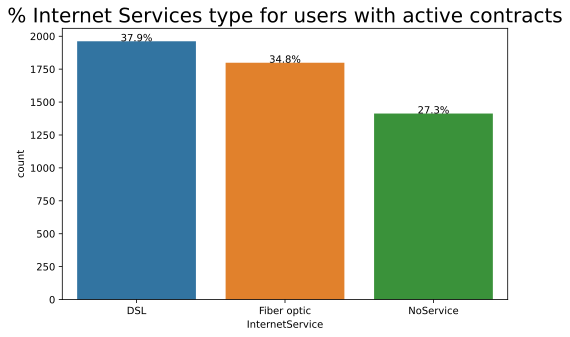

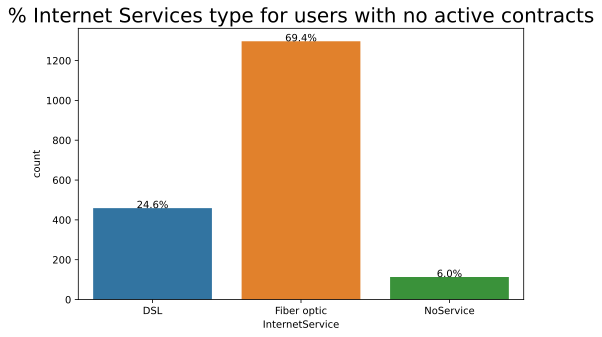

In [22]:
plt.figure(figsize = (8,5))
total = float(len(df.query('EndDate == "No"')))
ax = sns.countplot(x="InternetService", data=df.query('EndDate == "No"'))
plt.title('% Internet Services type for users with active contracts', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()
plt.figure(figsize = (8,5))
total = float(len(df.query('EndDate != "No"')))
ax = sns.countplot(x="InternetService", data=df.query('EndDate != "No"'))
plt.title('% Internet Services type for users with no active contracts', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

We can notice that the customers who left used more Fiber optic, it may be worth paying attention to the quality of service and the monthly fee compared to other competitors.
Such graphs also suggest that people who have not left us have been with us for a long time and since then most have not changed the Internet, still using the old DSL technology. It could be older people, since everything suits them, they do not leave the company.

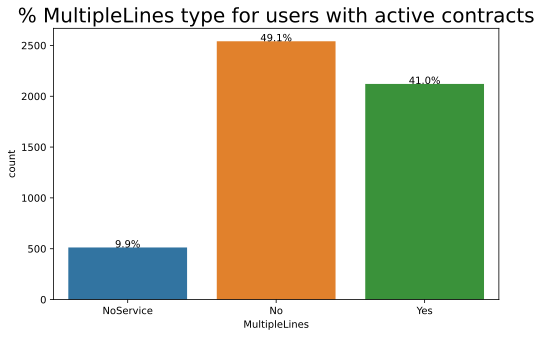

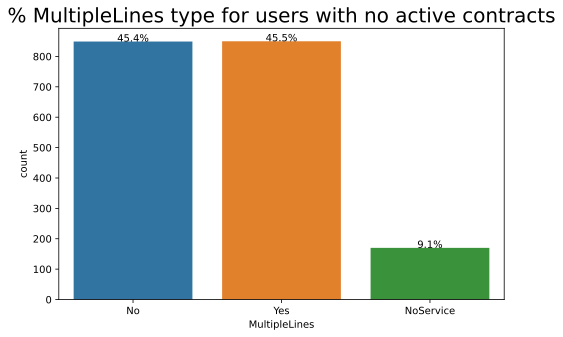

In [23]:
plt.figure(figsize = (8,5))
total = float(len(df.query('EndDate == "No"')))
ax = sns.countplot(x="MultipleLines", data=df.query('EndDate == "No"'))
plt.title('% MultipleLines type for users with active contracts', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()
plt.figure(figsize = (8,5))
total = float(len(df.query('EndDate != "No"')))
ax = sns.countplot(x="MultipleLines", data=df.query('EndDate != "No"'))
plt.title('% MultipleLines type for users with no active contracts', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Now let's compare the behavior of the clients of these two groups. For each group, we construct 1) the share of telephone users; 2) share of Internet users.

In [24]:
# create a function
def conditions(s):
    if (s['MultipleLines'] != 'NoService') & (s['InternetService'] != 'NoService'):
        return 'AllService'
    if (s['MultipleLines'] != 'NoService') & (s['InternetService'] == 'NoService'):
        return 'Only Phone'
    if (s['MultipleLines'] == 'NoService') & (s['InternetService'] != 'NoService'):
        return 'Only Internet'
    else:
        return 'NoService'

In [25]:
# create a new column based on condition
df['Service'] = df.apply(conditions, axis=1)

In [26]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Service
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,NoService,Only Internet
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,AllService
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,AllService
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NoService,Only Internet
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,AllService


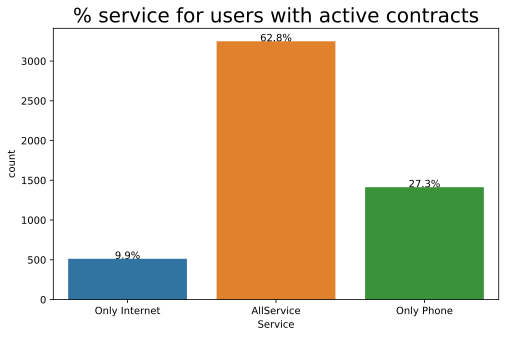

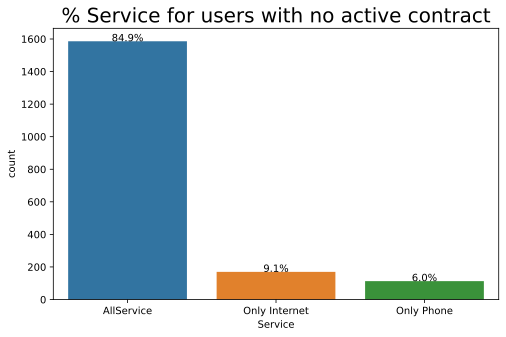

In [27]:
plt.figure(figsize = (8,5))
total = float(len(df.query('EndDate == "No"')))
ax = sns.countplot(x="Service", data=df.query('EndDate == "No"'))
plt.title('% service for users with active contracts', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()
plt.figure(figsize = (8,5))
total = float(len(df.query('EndDate != "No"')))
ax = sns.countplot(x="Service", data=df.query('EndDate != "No"'))
plt.title('% Service for users with no active contract', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Majority use both phone and internet. For active clients, the proportion of those who only use the phone is higher.

We can assume that those who left are either older or connected to the Internet for a short time for some kind of action.

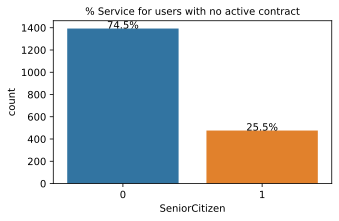

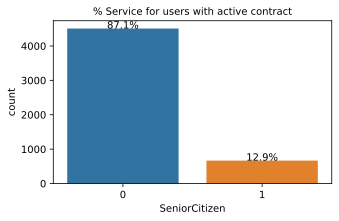

In [28]:
plt.figure(figsize = (5,3))
total = float(len(df.query('EndDate != "No"')))
ax = sns.countplot(x="SeniorCitizen", data=df.query('EndDate != "No"'))
plt.title('% Service for users with no active contract', fontsize=10)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()
plt.figure(figsize = (5,3))
total = float(len(df.query('EndDate == "No"')))
ax = sns.countplot(x="SeniorCitizen", data=df.query('EndDate == "No"'))
plt.title('% Service for users with active contract', fontsize=10)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

### <a id="2">2. Data preparation</a>

In this part we'll check missing values, duplicates, data type and correlation. We'll see if we need additional features. At the end, we prepare the data for training and divide the data into training and test sets.

In [29]:
df.duplicated().sum()

0

In [30]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Service
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,NoService,Only Internet
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,AllService
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,AllService
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NoService,Only Internet
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,AllService


In [31]:
for column in ["OnlineSecurity","OnlineBackup","TechSupport","DeviceProtection","StreamingTV","StreamingMovies"]:
    df[column] = df[column].fillna("No")

In [32]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [34]:
missing_percent=df.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

customerID          0.0
Dependents          0.0
MultipleLines       0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
Partner             0.0
BeginDate           0.0
SeniorCitizen       0.0
gender              0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Type                0.0
EndDate             0.0
Service             0.0
dtype: float64

In [35]:
df['churn']=df['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

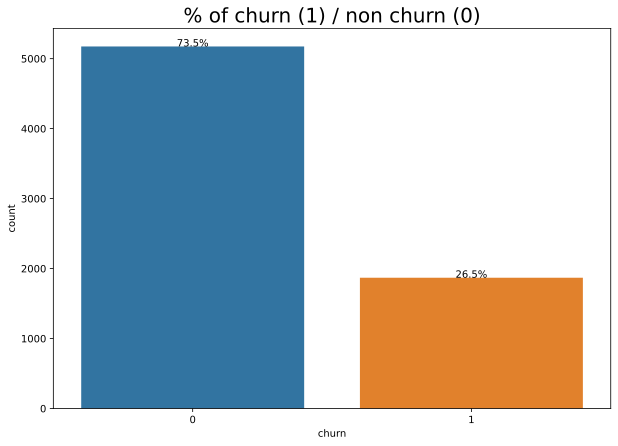

In [36]:
plt.figure(figsize = (10,7))
total = float(len(df))
ax = sns.countplot(x="churn", data=df)
plt.title('% of churn (1) / non churn (0)', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

We can see disbalance in our data.

In [37]:
df['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [38]:
df['BeginDate'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

We need an additional column:

In [39]:
df.loc[df['EndDate']=='No','EndDate'] = pd.to_datetime('2020-02-01 00:00:00')

In [40]:
df['time']=(pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days

<AxesSubplot:>

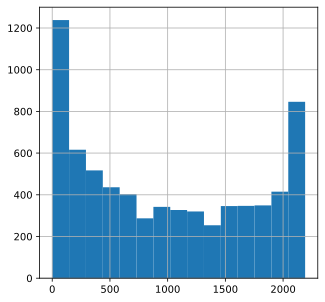

In [41]:
df['time'].hist(bins=15, figsize=(5, 5)) 

In [42]:
# create a function
def conditions(s):
    if (s['time'] < 50):
        return '<50'
    if (s['time'] >= 50) & (s['time'] <200):
        return '50-200'
    if (s['time'] >= 200) & (s['time'] <500):
        return '200-500'
    if (s['time'] >= 500) & (s['time'] <1000):
        return '500-1000'
    else:
        return '>1000'

df['time_groups'] = df.apply(conditions, axis=1)

In [43]:
df.groupby(["time_groups"])["customerID"].count()

time_groups
200-500     1069
50-200       857
500-1000    1225
<50          624
>1000       3268
Name: customerID, dtype: int64

We can delete columns that we don't need:

In [44]:
df = df.drop(["BeginDate","EndDate",'customerID','time_groups'], axis=1)

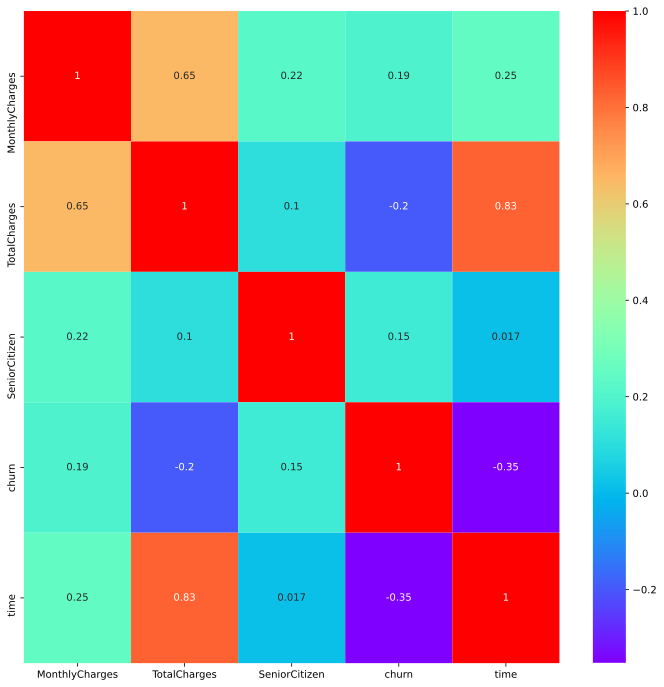

In [45]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(), annot = True, cmap="rainbow")
plt.show()

Multicollinearity occurs when more than two factors are linearly (strongly) related. In machine learning, multicollinearity can cause a model to overfit, leading to incorrect results. We can see from the graph that "total charges" and 'time' have a big dependency, so this column should be removed.

As we have a lot of categorical features, we can try Phik:

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'churn', 'time']


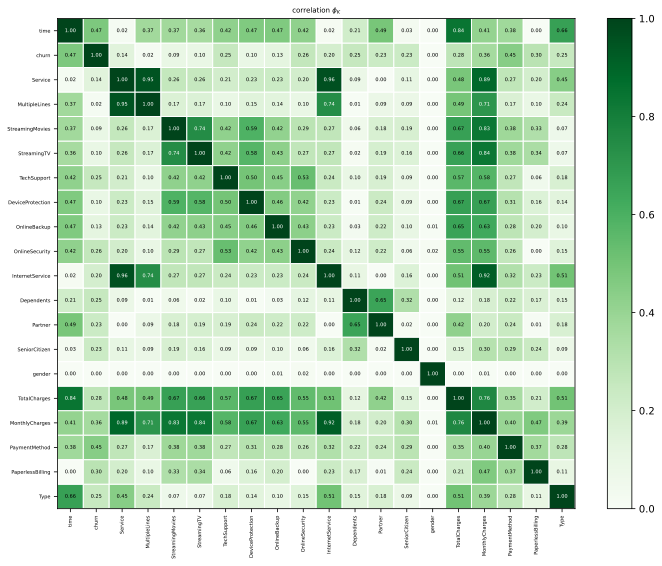

In [46]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.5, 
                        figsize=(10, 8))
plt.tight_layout()

We will divide the data into training and test datasets. We will add validation dataset as well. The training data is used to "train" the model, the validation data is used to find the best model architecture, and delayed sampling is reserved for the final evaluation of our model.

In [47]:
target=df['churn']
features=df.drop(['churn','TotalCharges','Service'],axis=1)

In [48]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.1, random_state=12345)

In [49]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape, features_valid.shape, target_valid.shape

((5704, 17), (5704,), (705, 17), (705,), (634, 17), (634,))

In [50]:
len(features_train)/len(df), len(features_test)/len(df),len(features_valid)/len(df)

(0.8098821524918358, 0.10009938946471673, 0.0900184580434474)

### <a id="3">3. Model training</a>

We will look at 4 models: Logistic Regression, Decision Tree, KNN, RandomForestClassifier and catboost. We'll check different paramerters.

Creating a table to help compare models in the analysis.

In [51]:
eval_table = {"models": ["Log_Regression","DecisionTree","DecisionTree_gridsearch","KNN","KNN_grid","Random_Forest","Random_Forest_grid","catboost","catboost_grid"],"ROC AUC": [0.0]*9}
eval_table=pd.DataFrame(eval_table)
print(eval_table)

                    models  ROC AUC
0           Log_Regression      0.0
1             DecisionTree      0.0
2  DecisionTree_gridsearch      0.0
3                      KNN      0.0
4                 KNN_grid      0.0
5            Random_Forest      0.0
6       Random_Forest_grid      0.0
7                 catboost      0.0
8            catboost_grid      0.0


We'll add some functions. And we'll make rare class not so rare in the data using upsampling

In [52]:
def curves(model, name):
    roc_auc = roc_auc_score(target_test, model.predict(features_test))
    fpr, tpr, thresholds = roc_curve(target_test, model.predict_proba(features_test)[:,1])
    precision, recall, thresholds = precision_recall_curve(target_test, model.predict_proba(features_test)[:, 1])
    plt.figure(figsize=(3, 3))
    plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.savefig('ROC')
    plt.show()
    plt.figure(figsize=(3, 3))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 

In [53]:
def features(model):
    feat_dict= {}
    for col, val in sorted(zip(features_train.columns, model.feature_importances_),key=lambda x:x[1],reverse=True):
      feat_dict[col]=val
    
    feat_i = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_i.Importance    
    idx = feat_i.Feature
    plt.figure(figsize=(10,8))
    clrs = ['green' if (x < max(values)) else 'red' for x in values ]
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict customer Churn')
    plt.show()

In [54]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [55]:
print('Not balanced')
display(target_train.value_counts(normalize=True))
target_train.value_counts()

Not balanced


0    0.734572
1    0.265428
Name: churn, dtype: float64

0    4190
1    1514
Name: churn, dtype: int64

In [56]:
print('Balanced')
display(target_upsampled.value_counts(normalize=True))
target_upsampled.value_counts()

Balanced


1    0.59106
0    0.40894
Name: churn, dtype: float64

1    6056
0    4190
Name: churn, dtype: int64

<AxesSubplot:>

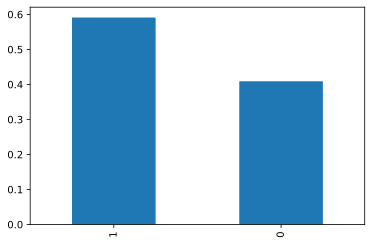

In [57]:
target_upsampled.value_counts(normalize=True).plot.bar()

We'll apply the Label Encoder & Ordinal Encoder to the columns where we have text. This will be required for all models except boosting. Let's apply ordinal encoding for 'Type','PaymentMethod','InternetService'.

In [58]:
from sklearn.preprocessing import LabelEncoder

features_upsampled_c=features_upsampled
features_test_c=features_test
features_valid_c=features_valid

lb = LabelEncoder() 
for i in ['PaperlessBilling','Partner','Dependents',"OnlineSecurity","OnlineBackup","TechSupport","DeviceProtection","StreamingTV","StreamingMovies",'MultipleLines','gender']:
    features_upsampled_c[i] = lb.fit_transform(features_upsampled[i])
    features_test_c[i] = lb.fit_transform(features_test[i])
    features_valid_c[i] = lb.fit_transform(features_valid[i])

In [59]:
enc = OrdinalEncoder()
for i in ['Type','PaymentMethod','InternetService']:
    features_upsampled_c[[i]] = enc.fit_transform(features_upsampled[[i]]).astype(int)
    features_test_c[[i]] = enc.fit_transform(features_test[[i]]).astype(int)
    features_valid_c[[i]] = enc.fit_transform(features_valid[[i]]).astype(int)

In [60]:
features_upsampled_c

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,time
1879,0,1,2,70.05,1,0,0,0,1,0,0,0,0,0,0,0,31
1776,2,1,0,25.00,1,1,1,0,2,0,0,0,0,0,0,2,2191
1509,0,1,2,76.65,1,0,0,0,1,0,0,1,0,0,0,0,518
5894,0,1,1,100.85,1,0,0,0,1,0,1,0,0,1,1,2,1369
5484,2,1,2,99.35,1,0,1,1,1,0,0,0,1,1,1,2,2102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5628,0,1,2,96.65,0,0,0,0,1,1,1,0,0,1,0,2,395
215,0,1,0,58.75,0,0,1,0,0,1,1,1,0,1,1,1,1737
2390,1,0,2,19.80,0,0,1,1,2,0,0,0,0,0,0,0,245
4370,1,0,3,80.90,0,0,1,0,0,1,0,1,1,1,1,0,641


Another important step in feature engineering is to scale the data as for e.g. logistic regression is sensitive to whether or not the data has been scaled

In [61]:
features_upsampled_sc=features_upsampled
features_test_sc=features_test
features_valid_sc=features_valid
numeric_cols = ["MonthlyCharges", "time"]
scaler = StandardScaler()
scaler.fit(features_upsampled[numeric_cols])
features_upsampled_sc[numeric_cols] = scaler.transform(features_upsampled[numeric_cols])
features_test_sc[numeric_cols] = scaler.transform(features_test[numeric_cols])
features_valid_sc[numeric_cols] = scaler.transform(features_valid[numeric_cols])

In [62]:
features_upsampled_c_sc=features_upsampled_c
features_test_c_sc=features_test_c
features_valid_c_sc=features_valid_c
numeric_cols = ["MonthlyCharges", "time"]
scaler = StandardScaler()
scaler.fit(features_upsampled_c[numeric_cols])
features_upsampled_c_sc[numeric_cols] = scaler.transform(features_upsampled_c[numeric_cols])
features_test_c_sc[numeric_cols] = scaler.transform(features_test_c[numeric_cols])
features_valid_c_sc[numeric_cols] = scaler.transform(features_valid_c[numeric_cols])

### Logistic Regression

For logistic regression, we choose a sample with scaling and data encoding:

In [63]:
log = LogisticRegression(random_state=12345)
log.fit(features_upsampled_c_sc, target_upsampled)

LogisticRegression(random_state=12345)

In [64]:
target_pred = log.predict(features_valid_c_sc)

In [65]:
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.92      0.64      0.75       469
           1       0.45      0.84      0.58       165

    accuracy                           0.69       634
   macro avg       0.68      0.74      0.67       634
weighted avg       0.80      0.69      0.71       634



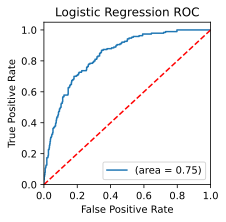

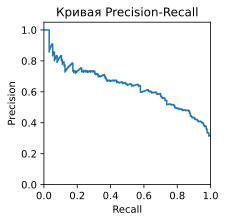

In [66]:
curves(log,'Logistic Regression ROC')

For the ROC curve: the closer the curve is to the upper left corner, the higher the predictive power of the model. The higher the Precision-Recall curve, the better the model.

In [67]:
log_r=roc_auc_score(target_valid, log.predict_proba(features_valid_c_sc)[:,1])
print(log_r)

0.8300316598824061


In [68]:
eval_table["ROC AUC"].values[0] = log_r
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.000000
2,DecisionTree_gridsearch,0.000000
3,KNN,0.000000
4,KNN_grid,0.000000
5,Random_Forest,0.000000
6,Random_Forest_grid,0.000000
7,catboost,0.000000
8,catboost_grid,0.000000


In [69]:
def features2(model):
    feat_dict= {}
    for col, val in sorted(zip(features_train.columns, model.coef_[0]),key=lambda x:x[1],reverse=True):
      feat_dict[col]=val
    
    feat_i = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_i.Importance    
    idx = feat_i.Feature
    plt.figure(figsize=(10,8))
    clrs = ['green' if (x < max(values)) else 'red' for x in values ]
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict customer Churn')
    plt.show()

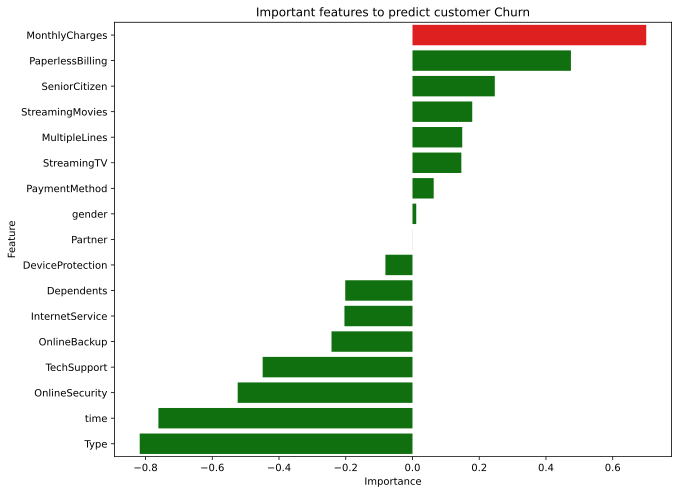

In [70]:
features2(log)

It's interesting that in principle we do not need many features and most likely they could be removed.

### DecisionTreeClassifier

We dont need sampling but we leave the encoding.

In [71]:
tree = DecisionTreeClassifier(random_state=12345)
tree.fit(features_upsampled_c, target_upsampled)

DecisionTreeClassifier(random_state=12345)

In [72]:
target_pred = tree.predict(features_valid_c)
print(classification_report(target_valid, target_pred))
tree_score=roc_auc_score(target_valid, tree.predict_proba(features_valid_c)[:,1])
print(tree_score)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       469
           1       0.55      0.54      0.54       165

    accuracy                           0.76       634
   macro avg       0.69      0.69      0.69       634
weighted avg       0.76      0.76      0.76       634

0.6903275828648964


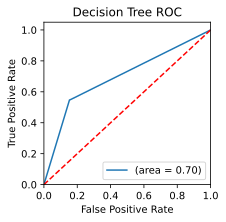

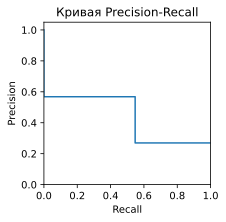

In [73]:
curves(tree,'Decision Tree ROC')

In [74]:
eval_table["ROC AUC"].values[1] = tree_score
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.000000
3,KNN,0.000000
4,KNN_grid,0.000000
5,Random_Forest,0.000000
6,Random_Forest_grid,0.000000
7,catboost,0.000000
8,catboost_grid,0.000000


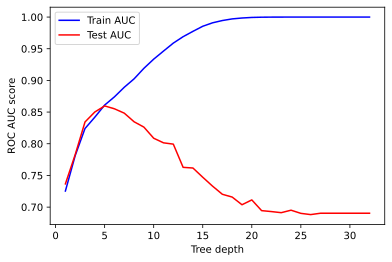

In [75]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=12345)
    tree.fit(features_upsampled_c, target_upsampled)
    train_pred = tree.predict(features_upsampled_c)
    roc_auc = roc_auc_score(target_upsampled, tree.predict_proba(features_upsampled_c)[:,1])
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = tree.predict(features_valid)
    roc_auc = roc_auc_score(target_valid, tree.predict_proba(features_valid)[:,1])
    # Add auc score to previous test results
    test_results.append(roc_auc)
line1 = plt.plot(max_depths, train_results, "b", label='Train AUC')
line2 = plt.plot(max_depths, test_results, "r", label='Test AUC')
plt.legend(loc="upper left")
plt.ylabel("ROC AUC score")
plt.xlabel("Tree depth")
plt.show()

We should choose the depth parameter lower than 10, otherwise we might get overfitting on real data.

Checking the model via gridsearch:

In [76]:
tree= DecisionTreeClassifier(random_state=12345)
param_grid = {
    'criterion':['gini','entropy'], 
    'max_depth' : range(1,8),
    "min_samples_split":range(2,16),
    "min_samples_leaf":range(1,5)}
grid_search = GridSearchCV(tree,param_grid=param_grid,cv=5)
grid_search.fit(features_upsampled_c, target_upsampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 8),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 16)})

In [77]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [78]:
grid_search=grid_search.best_estimator_

In [79]:
tree_grid=roc_auc_score(target_valid, grid_search.predict_proba(features_valid)[:,1])
print(tree_grid)

0.8483297796730633


In [80]:
eval_table["ROC AUC"].values[2] = tree_grid
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.000000
4,KNN_grid,0.000000
5,Random_Forest,0.000000
6,Random_Forest_grid,0.000000
7,catboost,0.000000
8,catboost_grid,0.000000


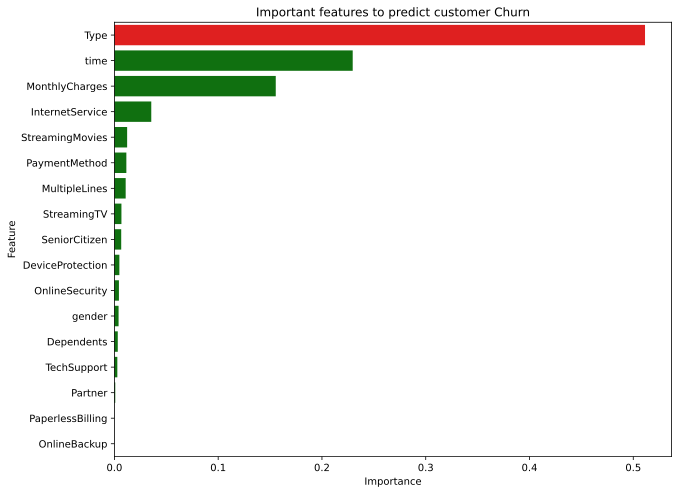

In [81]:
features(grid_search)

Type of Contract is one of the important features.

### KNN

For KNN we should have sampling & encoding.

In [82]:
knn = KNeighborsClassifier()
knn.fit(features_upsampled_c_sc, target_upsampled)

KNeighborsClassifier()

In [83]:
target_pred = knn.predict(features_valid)
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.89      0.60      0.72       469
           1       0.41      0.79      0.54       165

    accuracy                           0.65       634
   macro avg       0.65      0.70      0.63       634
weighted avg       0.77      0.65      0.67       634



In [84]:
knn=roc_auc_score(target_valid, knn.predict_proba(features_valid)[:,1])
print(knn)

0.765193512954707


In [85]:
eval_table["ROC AUC"].values[3] = knn
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.000000
5,Random_Forest,0.000000
6,Random_Forest_grid,0.000000
7,catboost,0.000000
8,catboost_grid,0.000000


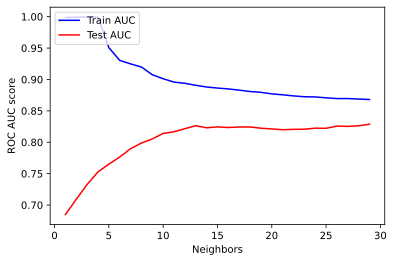

In [86]:
neighbors = list(range(1,30))
train_results = []
test_results = []

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(features_upsampled_c_sc, target_upsampled)
    train_pred = model.predict(features_upsampled_c_sc)
    roc_auc = roc_auc_score(target_upsampled, model.predict_proba(features_upsampled_c_sc)[:,1])
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = model.predict(features_valid)
    roc_auc = roc_auc_score(target_valid,model.predict_proba(features_valid)[:,1])
    # Add auc score to previous test results
    test_results.append(roc_auc)
line1 = plt.plot(neighbors, train_results, "b", label='Train AUC')
line2 = plt.plot(neighbors, test_results, "r", label='Test AUC')
plt.legend(loc="upper left")
plt.ylabel("ROC AUC score")
plt.xlabel("Neighbors")
plt.show()

We need neighbors parameter greater than 10.

In [87]:
parameters = {
    'n_neighbors': list(range(10,30)),
    'weights' : ['uniform','distance'],
'leaf_size': (10,20),
    'p': (1,2)
}

In [88]:
Grid_knn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = parameters, 
                          cv = 5
                       )
Grid_knn.fit(features_upsampled_c_sc, target_upsampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': (10, 20),
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28,
                                         29],
                         'p': (1, 2), 'weights': ['uniform', 'distance']})

In [89]:
Grid_knn.best_params_

{'leaf_size': 10, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

In [90]:
Grid_knn=Grid_knn.best_estimator_

In [91]:
Grid_knn=roc_auc_score(target_valid, Grid_knn.predict_proba(features_valid)[:,1])
print(Grid_knn)

0.7979324158428636


In [92]:
eval_table["ROC AUC"].values[4] = Grid_knn
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.797932
5,Random_Forest,0.000000
6,Random_Forest_grid,0.000000
7,catboost,0.000000
8,catboost_grid,0.000000


### Random Forest Classifier

For RandomForestClassifier we don't need sampling but encoding.

In [93]:
rf = RandomForestClassifier(random_state=12345)
rf.fit(features_upsampled_c, target_upsampled)

RandomForestClassifier(random_state=12345)

In [94]:
target_pred = rf.predict(features_valid)
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       469
           1       0.64      0.64      0.64       165

    accuracy                           0.81       634
   macro avg       0.76      0.76      0.76       634
weighted avg       0.81      0.81      0.81       634



In [95]:
rf=roc_auc_score(target_valid, rf.predict_proba(features_valid)[:,1])
print(rf)

0.8532984428506818


In [96]:
eval_table["ROC AUC"].values[5] = rf
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.797932
5,Random_Forest,0.853298
6,Random_Forest_grid,0.000000
7,catboost,0.000000
8,catboost_grid,0.000000


In [97]:
parameters = {
    'bootstrap': [True],
    'max_depth': [2,4,8,16,20],
    'max_features': [2,3,6,8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100,150,500]
}

In [98]:
grid_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=12345), param_grid = parameters, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_rf.fit(features_upsampled_c, target_upsampled)
grid_rf.best_params_

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 150}

In [99]:
grid_rf=grid_rf.best_estimator_

In [100]:
grid_rf=roc_auc_score(target_valid, grid_rf.predict_proba(features_valid)[:,1])
print(grid_rf)

0.8680493635717516


In [101]:
eval_table["ROC AUC"].values[6] = grid_rf
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.797932
5,Random_Forest,0.853298
6,Random_Forest_grid,0.868049
7,catboost,0.000000
8,catboost_grid,0.000000


### Catboost

For catboost we dont need sampling or encoding.

In [102]:
CBC = CatBoostClassifier(random_state=12345)
CBC.fit(features_upsampled, target_upsampled)

Learning rate set to 0.027825
0:	learn: 0.6787112	total: 62ms	remaining: 1m 1s
1:	learn: 0.6665321	total: 65.9ms	remaining: 32.9s
2:	learn: 0.6558213	total: 69.4ms	remaining: 23.1s
3:	learn: 0.6442927	total: 72.8ms	remaining: 18.1s
4:	learn: 0.6358191	total: 75.1ms	remaining: 14.9s
5:	learn: 0.6257353	total: 78.3ms	remaining: 13s
6:	learn: 0.6161278	total: 81.4ms	remaining: 11.5s
7:	learn: 0.6069990	total: 84.4ms	remaining: 10.5s
8:	learn: 0.5995137	total: 88.2ms	remaining: 9.71s
9:	learn: 0.5897614	total: 91.6ms	remaining: 9.07s
10:	learn: 0.5818675	total: 94.8ms	remaining: 8.53s
11:	learn: 0.5765843	total: 96.7ms	remaining: 7.96s
12:	learn: 0.5697053	total: 100ms	remaining: 7.59s
13:	learn: 0.5641572	total: 103ms	remaining: 7.24s
14:	learn: 0.5575353	total: 106ms	remaining: 6.98s
15:	learn: 0.5522349	total: 110ms	remaining: 6.75s
16:	learn: 0.5474230	total: 113ms	remaining: 6.52s
17:	learn: 0.5422078	total: 116ms	remaining: 6.35s
18:	learn: 0.5379662	total: 120ms	remaining: 6.18s
19:

189:	learn: 0.3864145	total: 691ms	remaining: 2.95s
190:	learn: 0.3860815	total: 694ms	remaining: 2.94s
191:	learn: 0.3857097	total: 697ms	remaining: 2.93s
192:	learn: 0.3853726	total: 699ms	remaining: 2.92s
193:	learn: 0.3849437	total: 703ms	remaining: 2.92s
194:	learn: 0.3846003	total: 706ms	remaining: 2.92s
195:	learn: 0.3842042	total: 709ms	remaining: 2.91s
196:	learn: 0.3837358	total: 713ms	remaining: 2.9s
197:	learn: 0.3829492	total: 715ms	remaining: 2.9s
198:	learn: 0.3825908	total: 719ms	remaining: 2.89s
199:	learn: 0.3822444	total: 722ms	remaining: 2.89s
200:	learn: 0.3818300	total: 726ms	remaining: 2.88s
201:	learn: 0.3815047	total: 729ms	remaining: 2.88s
202:	learn: 0.3812172	total: 733ms	remaining: 2.88s
203:	learn: 0.3809099	total: 737ms	remaining: 2.88s
204:	learn: 0.3805979	total: 740ms	remaining: 2.87s
205:	learn: 0.3803827	total: 743ms	remaining: 2.86s
206:	learn: 0.3800588	total: 745ms	remaining: 2.85s
207:	learn: 0.3797219	total: 748ms	remaining: 2.85s
208:	learn: 0.

362:	learn: 0.3353912	total: 1.28s	remaining: 2.25s
363:	learn: 0.3351372	total: 1.29s	remaining: 2.25s
364:	learn: 0.3349460	total: 1.29s	remaining: 2.24s
365:	learn: 0.3343570	total: 1.29s	remaining: 2.24s
366:	learn: 0.3340290	total: 1.3s	remaining: 2.24s
367:	learn: 0.3336749	total: 1.3s	remaining: 2.23s
368:	learn: 0.3333781	total: 1.3s	remaining: 2.23s
369:	learn: 0.3332221	total: 1.31s	remaining: 2.23s
370:	learn: 0.3329191	total: 1.31s	remaining: 2.23s
371:	learn: 0.3327606	total: 1.31s	remaining: 2.22s
372:	learn: 0.3326441	total: 1.32s	remaining: 2.22s
373:	learn: 0.3325283	total: 1.32s	remaining: 2.21s
374:	learn: 0.3323365	total: 1.33s	remaining: 2.21s
375:	learn: 0.3321554	total: 1.33s	remaining: 2.21s
376:	learn: 0.3318850	total: 1.33s	remaining: 2.21s
377:	learn: 0.3314313	total: 1.34s	remaining: 2.2s
378:	learn: 0.3309231	total: 1.34s	remaining: 2.2s
379:	learn: 0.3307785	total: 1.34s	remaining: 2.19s
380:	learn: 0.3303936	total: 1.35s	remaining: 2.19s
381:	learn: 0.330

526:	learn: 0.2936945	total: 1.86s	remaining: 1.67s
527:	learn: 0.2934500	total: 1.86s	remaining: 1.67s
528:	learn: 0.2933571	total: 1.87s	remaining: 1.66s
529:	learn: 0.2930690	total: 1.87s	remaining: 1.66s
530:	learn: 0.2929250	total: 1.87s	remaining: 1.65s
531:	learn: 0.2927646	total: 1.88s	remaining: 1.65s
532:	learn: 0.2925980	total: 1.88s	remaining: 1.65s
533:	learn: 0.2923709	total: 1.88s	remaining: 1.64s
534:	learn: 0.2920371	total: 1.89s	remaining: 1.64s
535:	learn: 0.2918869	total: 1.89s	remaining: 1.64s
536:	learn: 0.2916754	total: 1.89s	remaining: 1.63s
537:	learn: 0.2915300	total: 1.9s	remaining: 1.63s
538:	learn: 0.2913141	total: 1.9s	remaining: 1.63s
539:	learn: 0.2912073	total: 1.9s	remaining: 1.62s
540:	learn: 0.2909879	total: 1.91s	remaining: 1.62s
541:	learn: 0.2908564	total: 1.91s	remaining: 1.61s
542:	learn: 0.2907261	total: 1.92s	remaining: 1.61s
543:	learn: 0.2904789	total: 1.92s	remaining: 1.61s
544:	learn: 0.2903316	total: 1.92s	remaining: 1.6s
545:	learn: 0.29

696:	learn: 0.2625933	total: 2.45s	remaining: 1.06s
697:	learn: 0.2625019	total: 2.45s	remaining: 1.06s
698:	learn: 0.2622721	total: 2.46s	remaining: 1.06s
699:	learn: 0.2621404	total: 2.46s	remaining: 1.05s
700:	learn: 0.2619949	total: 2.46s	remaining: 1.05s
701:	learn: 0.2617987	total: 2.47s	remaining: 1.05s
702:	learn: 0.2615909	total: 2.47s	remaining: 1.04s
703:	learn: 0.2614474	total: 2.48s	remaining: 1.04s
704:	learn: 0.2613754	total: 2.48s	remaining: 1.04s
705:	learn: 0.2612789	total: 2.48s	remaining: 1.03s
706:	learn: 0.2612016	total: 2.48s	remaining: 1.03s
707:	learn: 0.2610831	total: 2.49s	remaining: 1.03s
708:	learn: 0.2609216	total: 2.49s	remaining: 1.02s
709:	learn: 0.2607868	total: 2.49s	remaining: 1.02s
710:	learn: 0.2606950	total: 2.5s	remaining: 1.01s
711:	learn: 0.2605443	total: 2.5s	remaining: 1.01s
712:	learn: 0.2602194	total: 2.5s	remaining: 1.01s
713:	learn: 0.2601214	total: 2.51s	remaining: 1s
714:	learn: 0.2600266	total: 2.51s	remaining: 1s
715:	learn: 0.2598691

869:	learn: 0.2378980	total: 3.04s	remaining: 454ms
870:	learn: 0.2377307	total: 3.04s	remaining: 451ms
871:	learn: 0.2376140	total: 3.05s	remaining: 447ms
872:	learn: 0.2374938	total: 3.05s	remaining: 444ms
873:	learn: 0.2371923	total: 3.06s	remaining: 440ms
874:	learn: 0.2369485	total: 3.06s	remaining: 437ms
875:	learn: 0.2368323	total: 3.06s	remaining: 433ms
876:	learn: 0.2367560	total: 3.06s	remaining: 430ms
877:	learn: 0.2366564	total: 3.07s	remaining: 426ms
878:	learn: 0.2364795	total: 3.07s	remaining: 423ms
879:	learn: 0.2364058	total: 3.08s	remaining: 419ms
880:	learn: 0.2362956	total: 3.08s	remaining: 416ms
881:	learn: 0.2361370	total: 3.08s	remaining: 413ms
882:	learn: 0.2360222	total: 3.09s	remaining: 409ms
883:	learn: 0.2359271	total: 3.09s	remaining: 406ms
884:	learn: 0.2358280	total: 3.09s	remaining: 402ms
885:	learn: 0.2357208	total: 3.1s	remaining: 399ms
886:	learn: 0.2355926	total: 3.1s	remaining: 395ms
887:	learn: 0.2355033	total: 3.1s	remaining: 392ms
888:	learn: 0.2

In [103]:
target_pred = CBC.predict(features_valid)
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       469
           1       0.65      0.87      0.74       165

    accuracy                           0.84       634
   macro avg       0.80      0.85      0.81       634
weighted avg       0.87      0.84      0.85       634



In [104]:
CB=roc_auc_score(target_valid, CBC.predict_proba(features_valid)[:,1])
print(CB)

0.9249596174969308


It is possible that with such a result the model will not work well on real data.

In [105]:
eval_table["ROC AUC"].values[7] = CB
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.797932
5,Random_Forest,0.853298
6,Random_Forest_grid,0.868049
7,catboost,0.924960
8,catboost_grid,0.000000


In [106]:
parameters = {'depth'         : [1,2,3,4,5,6,7,8,9,10],
              'learning_rate' : [0.001,0.01,0.02,0.03,0.04,0.2],
              'iterations'    : [50,100,200],
              'l2_leaf_reg':[1,5,10,100],
              'border_count':[50,100,200]
              
                 }
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1,verbose=2)
Grid_CBC.fit(features_upsampled, target_upsampled)

Fitting 2 folds for each of 2160 candidates, totalling 4320 fits
0:	learn: 0.6003080	total: 7.09ms	remaining: 1.41s
1:	learn: 0.5455455	total: 12.5ms	remaining: 1.24s
2:	learn: 0.5061252	total: 16.9ms	remaining: 1.11s
3:	learn: 0.4770853	total: 20.7ms	remaining: 1.01s
4:	learn: 0.4600188	total: 26.3ms	remaining: 1.03s
5:	learn: 0.4461455	total: 30.5ms	remaining: 987ms
6:	learn: 0.4392898	total: 34.8ms	remaining: 961ms
7:	learn: 0.4316792	total: 39.3ms	remaining: 944ms
8:	learn: 0.4232058	total: 43ms	remaining: 913ms
9:	learn: 0.4176367	total: 48ms	remaining: 912ms
10:	learn: 0.4118513	total: 53ms	remaining: 911ms
11:	learn: 0.4068258	total: 61.2ms	remaining: 959ms
12:	learn: 0.4034216	total: 68.7ms	remaining: 989ms
13:	learn: 0.3986266	total: 74.4ms	remaining: 989ms
14:	learn: 0.3952922	total: 90.9ms	remaining: 1.12s
15:	learn: 0.3919198	total: 98.3ms	remaining: 1.13s
16:	learn: 0.3863509	total: 106ms	remaining: 1.14s
17:	learn: 0.3823175	total: 111ms	remaining: 1.13s
18:	learn: 0.3783

188:	learn: 0.1184626	total: 953ms	remaining: 55.5ms
189:	learn: 0.1179870	total: 958ms	remaining: 50.4ms
190:	learn: 0.1175519	total: 963ms	remaining: 45.4ms
191:	learn: 0.1170461	total: 967ms	remaining: 40.3ms
192:	learn: 0.1163429	total: 972ms	remaining: 35.2ms
193:	learn: 0.1154973	total: 976ms	remaining: 30.2ms
194:	learn: 0.1148617	total: 980ms	remaining: 25.1ms
195:	learn: 0.1144381	total: 984ms	remaining: 20.1ms
196:	learn: 0.1137140	total: 988ms	remaining: 15ms
197:	learn: 0.1128419	total: 992ms	remaining: 10ms
198:	learn: 0.1121237	total: 997ms	remaining: 5.01ms
199:	learn: 0.1114756	total: 1s	remaining: 0us


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f7f2bc25580>,
             n_jobs=-1,
             param_grid={'border_count': [50, 100, 200],
                         'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'iterations': [50, 100, 200],
                         'l2_leaf_reg': [1, 5, 10, 100],
                         'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.04, 0.2]},
             verbose=2)

In [107]:
Grid_CBC.best_params_

{'border_count': 200,
 'depth': 7,
 'iterations': 200,
 'l2_leaf_reg': 1,
 'learning_rate': 0.2}

In [108]:
Grid_CBC=Grid_CBC.best_estimator_

In [109]:
catboost_grid=roc_auc_score(target_valid, Grid_CBC.predict_proba(features_valid)[:,1])
print(catboost_grid)

0.9154228855721392


In [110]:
eval_table["ROC AUC"].values[8] = catboost_grid
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.797932
5,Random_Forest,0.853298
6,Random_Forest_grid,0.868049
7,catboost,0.924960
8,catboost_grid,0.915423


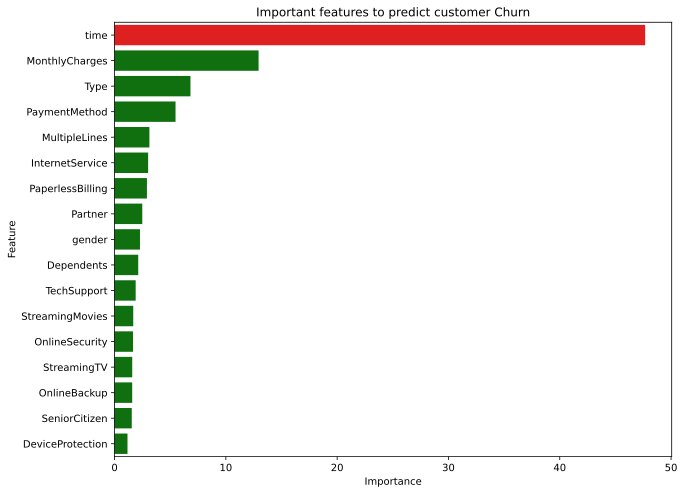

In [111]:
features(Grid_CBC)

Заметим что самые важные признаки: time, type of contract and internet service, мы уже заметили в анализе что те кто пользуется fibre чаще вышли из контракта

<div class="alert alert-block alert-info">
Протестируем на тестовой выборке: </div>

In [112]:
final_classifier = Grid_CBC
final_classifier.fit(features_upsampled, target_upsampled)

0:	learn: 0.6003080	total: 3.37ms	remaining: 671ms
1:	learn: 0.5455455	total: 8.42ms	remaining: 833ms
2:	learn: 0.5061252	total: 14.9ms	remaining: 981ms
3:	learn: 0.4770853	total: 19ms	remaining: 930ms
4:	learn: 0.4600188	total: 23.3ms	remaining: 908ms
5:	learn: 0.4461455	total: 26.7ms	remaining: 863ms
6:	learn: 0.4392898	total: 30.3ms	remaining: 837ms
7:	learn: 0.4316792	total: 34ms	remaining: 817ms
8:	learn: 0.4232058	total: 36.8ms	remaining: 780ms
9:	learn: 0.4176367	total: 40.2ms	remaining: 765ms
10:	learn: 0.4118513	total: 44ms	remaining: 756ms
11:	learn: 0.4068258	total: 47.5ms	remaining: 744ms
12:	learn: 0.4034216	total: 50.7ms	remaining: 730ms
13:	learn: 0.3986266	total: 54.4ms	remaining: 723ms
14:	learn: 0.3952922	total: 58.1ms	remaining: 717ms
15:	learn: 0.3919198	total: 61.8ms	remaining: 711ms
16:	learn: 0.3863509	total: 65.4ms	remaining: 704ms
17:	learn: 0.3823175	total: 69.6ms	remaining: 703ms
18:	learn: 0.3783497	total: 73.4ms	remaining: 699ms
19:	learn: 0.3764752	total: 

191:	learn: 0.1170461	total: 774ms	remaining: 32.3ms
192:	learn: 0.1163429	total: 778ms	remaining: 28.2ms
193:	learn: 0.1154973	total: 782ms	remaining: 24.2ms
194:	learn: 0.1148617	total: 787ms	remaining: 20.2ms
195:	learn: 0.1144381	total: 791ms	remaining: 16.2ms
196:	learn: 0.1137140	total: 796ms	remaining: 12.1ms
197:	learn: 0.1128419	total: 800ms	remaining: 8.08ms
198:	learn: 0.1121237	total: 804ms	remaining: 4.04ms
199:	learn: 0.1114756	total: 809ms	remaining: 0us


In [113]:
pred = final_classifier.predict(features_test)
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       515
           1       0.68      0.75      0.71       190

    accuracy                           0.84       705
   macro avg       0.79      0.81      0.80       705
weighted avg       0.84      0.84      0.84       705



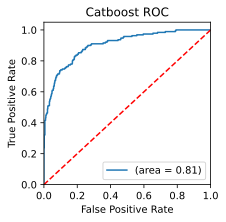

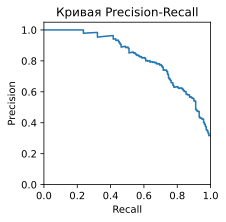

In [114]:
curves(Grid_CBC,'Catboost ROC')

In [115]:
score=roc_auc_score(target_test, final_classifier.predict_proba(features_test)[:,1])
print(score)

0.9029330608073582


We are getting high roc for our test set.

### <a id="4">4. Summary</a>

Сделаем заключение и сравним ROC AUC.

In [116]:
eval_table

,models,ROC AUC
0,Log_Regression,0.830032
1,DecisionTree,0.690328
2,DecisionTree_gridsearch,0.848330
3,KNN,0.765194
4,KNN_grid,0.797932
5,Random_Forest,0.853298
6,Random_Forest_grid,0.868049
7,catboost,0.924960
8,catboost_grid,0.915423


Our task was to predict the outflow of customers for a telecom operator. If the user plans to leave, he will be offered promotional codes and special conditions. We studied historical data on customer behavior, removed missing values and changed the data type of some parameters and added some features (time). Next, we have noticed that we have a class imbalance and did upsampling after we divided the data into sets. We considered 4 models: Logistic Regression, Decision Tree, KNN, RandomForestClassifier and catboost. For some models, it was necessary to use upsampling and data encoding. We compared different models in terms of AUC ROC, also looked at precision, recall & F1 score. We looked at different parameters: I think that catboost_grid has a very good result. This result was also tested on a test sample.